In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import kaggle_data_utils

import matplotlib.pyplot as plt
import numpy as np

# Analysis of Old Methodology

## LASSO on Select Features
Historically, the features which I've used are
- Seed
- Points per Game
- Win Percentage
- Offensive Efficiency
- Defensive Efficiency
- Field Goal Efficiency
- Offensive Rebound Percentage
- Effective Posession Ratio
- Margin

For a given game, I simply subtract the features of Team 2 from Team 1 and use that as the input to the model. I then shuffle and normalize these features before training.

In [3]:
dataset = kaggle_data_utils.Dataset(kaggle_data_utils.PRE2024_FEATURES, relative_path='..', one_hot_labels=False, normalize=True)

print(dataset.trainX.shape, dataset.trainY.shape)

(1182, 9) (1182,)


In [4]:
from sklearn import linear_model

# Pick 10 different regularization values to cross-validate against
# 10 fold cross-validation
clf = linear_model.LogisticRegressionCV(penalty='l1', Cs=10, cv=10, solver='liblinear', random_state=42, max_iter=1000)
clf.fit(dataset.trainX, dataset.trainY)

LogisticRegressionCV(cv=10, max_iter=1000, penalty='l1', random_state=42,
                     solver='liblinear')

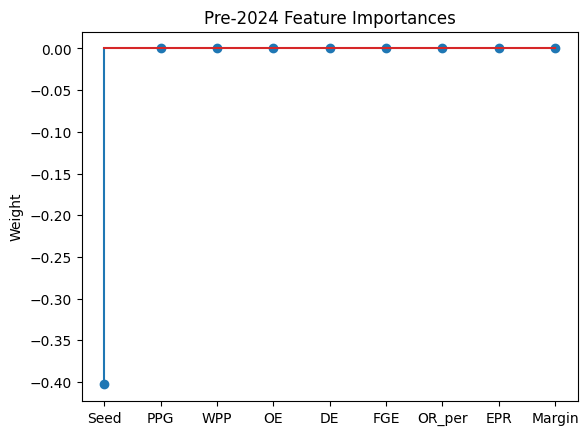

In [5]:
plt.stem(clf.coef_[0])
plt.xticks(list(range(dataset.trainX.shape[1])), dataset.feature_names)
plt.ylabel("Weight")
plt.title("Pre-2024 Feature Importances")
plt.show()

The results suggest that **Seed** contains most of the predictive info, makes sense

## LASSO on all Features
Lets try LASSO on all features

In [6]:
import pandas as pd

In [7]:
stats_df = pd.read_csv('../data/processed-data/all-season-stats.csv')
ALL_FEATURE_NAMES = set(stats_df.columns) - {'Season', 'TeamID', "Win"}
ALL_FEATURE_NAMES

{'Ast',
 'Blk',
 'DE',
 'DR',
 'EPR',
 'FGA',
 'FGA2',
 'FGA3',
 'FGE',
 'FGM',
 'FGM2',
 'FGM3',
 'FTA',
 'FTM',
 'Margin',
 'OE',
 'OR',
 'OR_per',
 'Opp_DR',
 'Opp_Score',
 'PF',
 'PPG',
 'Pos',
 'Score_mean',
 'Score_sum',
 'Stl',
 'TO',
 'WPP'}

In [14]:
dataset = kaggle_data_utils.Dataset(['Seed'] + list(ALL_FEATURE_NAMES), relative_path='..', one_hot_labels=False, normalize=True)

print(dataset.trainX.shape, dataset.trainY.shape)

(1182, 29) (1182,)


In [15]:
from sklearn import linear_model

# Pick 10 different regularization values to cross-validate against
# 5 fold cross-validation
clf = linear_model.LogisticRegressionCV(penalty='l1', Cs=10, cv=10, solver='liblinear', random_state=42, max_iter=1000)
clf.fit(dataset.trainX, dataset.trainY)

LogisticRegressionCV(cv=10, max_iter=1000, penalty='l1', random_state=42,
                     solver='liblinear')

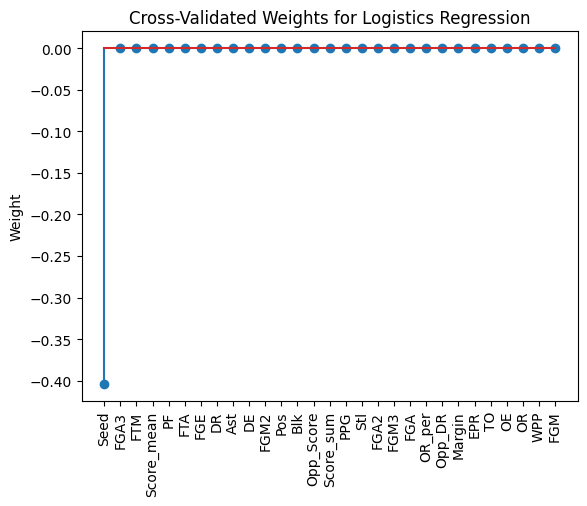

In [17]:
plt.stem(clf.coef_[0])
plt.xticks(list(range(dataset.trainX.shape[1])), dataset.feature_names, rotation=90)
plt.ylabel("Weight")
plt.title("Cross-Validated Weights for Logistics Regression")
plt.show()

The results suggest that **Seed** contains most of the predictive info, makes sense

## Seedless

Since Seed appears to have an outsized impact, what happens if we remove seed?

(1182, 28) (1182,)


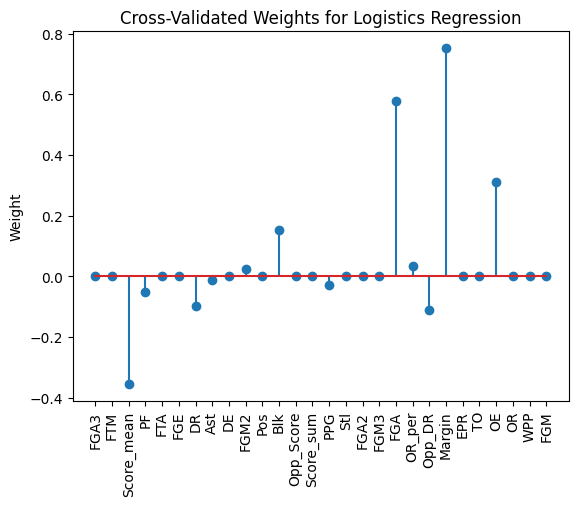

In [31]:
dataset = kaggle_data_utils.Dataset(list(ALL_FEATURE_NAMES), relative_path='..', one_hot_labels=False, normalize=True)

print(dataset.trainX.shape, dataset.trainY.shape)

# Pick 10 different regularization values to cross-validate against
# 5 fold cross-validation
clf = linear_model.LogisticRegressionCV(penalty='l1', Cs=20, cv=10, solver='liblinear', random_state=42, max_iter=1000)
clf.fit(dataset.trainX, dataset.trainY)

plt.stem(clf.coef_[0])
plt.xticks(list(range(dataset.trainX.shape[1])), dataset.feature_names, rotation=90)
plt.ylabel("Weight")
plt.title("Cross-Validated Weights for Logistics Regression")
plt.show()

(1182, 8) (1182,)


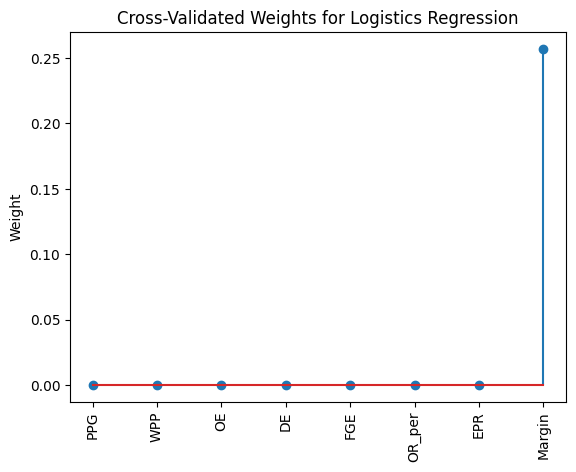

In [32]:
# Remove seed
dataset = kaggle_data_utils.Dataset(list(kaggle_data_utils.PRE2024_FEATURES[1:]), relative_path='..', one_hot_labels=False, normalize=True)

print(dataset.trainX.shape, dataset.trainY.shape)

# Pick 10 different regularization values to cross-validate against
# 10 fold cross-validation
clf = linear_model.LogisticRegressionCV(penalty='l1', Cs=10, cv=10, solver='liblinear', random_state=42, max_iter=1000)
clf.fit(dataset.trainX, dataset.trainY)

plt.stem(clf.coef_[0])
plt.xticks(list(range(dataset.trainX.shape[1])), dataset.feature_names, rotation=90)
plt.ylabel("Weight")
plt.title("Cross-Validated Weights for Logistics Regression")
plt.show()

## Summary

In the old methodology, the Seed is the dominant feature if we opt for a sparse model. Discounting seed, margin is the next best. Field goal attempts and Offensive efficiency also play a large role.

A weird result is that `score_mean` is significant with a negative weight. What that seems to indicate is that when Team 1 has a lower average game score than Team -1, the model is more likely to predict Team 1 wins.

# NMF & Regression
Instead of a classification problem, we can also cast the problem as a regression where we predict the score of each team in the matchup.

In [33]:
import summarize_kaggle

In [36]:
season_games = summarize_kaggle.load_regular_games(relative_path='..')
season_games.head()

,Season,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,1104,68,1328,62,27,58,3,14,11,...,10,16,22,10,22,8,18,9,2,20
1,2003,1272,70,1393,63,26,62,8,20,10,...,24,9,20,20,25,7,12,8,6,16
2,2003,1266,73,1437,61,24,58,8,18,17,...,26,14,23,31,22,9,12,2,5,23
3,2003,1296,56,1457,50,18,38,3,9,17,...,22,8,15,17,20,9,19,4,3,23
4,2003,1400,77,1208,71,30,61,6,14,11,...,16,17,27,21,15,12,10,7,1,14


In [38]:
game_scores = season_games[['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore']]
game_scores.head()

,Season,WTeamID,WScore,LTeamID,LScore
0,2003,1104,68,1328,62
1,2003,1272,70,1393,63
2,2003,1266,73,1437,61
3,2003,1296,56,1457,50
4,2003,1400,77,1208,71
